In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 1: [20pt] Allowed libraries: seaborn, matplotlib, pandas, sklearn

For this homework, use the churn dataset provided UCI Machine Learning Repository (The link to the dataset is provided in the HW2 assignment link on canvas). 

Part a)  [10 pt]
Normalize the numerical variables, encode the categorical variables (use one-hot encoding for categorical variables :https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) 

In [2]:
df = pd.read_csv('churn.txt')
df['Area Code'] = df['Area Code'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   object 
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [3]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
df.select_dtypes(include=('object')).describe()

,State,Area Code,Phone,Int'l Plan,VMail Plan,Churn?
count,3333,3333,3333,3333,3333,3333
unique,51,3,3333,2,2,2
top,WV,415,330-7483,no,no,False.
freq,106,1655,1,3010,2411,2850


In [5]:
df['Churn?'].value_counts()

False.    2850
True.      483
Name: Churn?, dtype: int64

Observations:
- Since Phone has no repeats, it supplies no information that we can separate Churn True/False.  If we supply it to our model, it would fit a weight of 0 (or asymptotically 0) to the Phone feature.  Instead of wasting our fitting time we should drop it instead.
- Oddly, there are 51 states rather than just 50.  It's probably Washington DC.  We should check though to make sure it's not an error.

In [6]:
df.drop('Phone', axis=1, inplace=True)

In [7]:
df['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

The 51st state is DC as expected.  There are no errors that we should address.

### Part B

Identify outliers and remove them from the dataset. The training data contains outliers which are defined as samples that are far from the others. With outlier detection, the goal is to fit the regions where the training data is the most concentrated, ignoring the deviant observations. Use any two outlier detection algorithms (e.g. one-class SVM, LOF, Isolation Forest, etc.) and perform at least two of the methods to the churn dataset. (https://scikit-learn.org/stable/modules/svm.html) 

Answer the following questions:
 
(b-1) are there any outliers on the dataset?

(b-2) do the methods agree on the detected outliers and why?

(b-3) what are the assumptions behind each method? Remove any outliers (using a single method) and then continue with this new, revised dataset.

#### Outlier Detection

Does it matter if we include the outcome feature in the detection dataset?  Intuitively, the outcome is an extremely important feature and we would expect there to be two clusters - one around each label.  So if we drop the outcome feature then we should expect to have more outliers since the observations are less likely to cluster cleanly.  The remaining features in the dataset need to be strong enough to define the clusters.

In [8]:
def run_outlier_detection(df_to_fit): 
    # n_jobs=-1 means to parallelize with all processors
    # nu=0.05 means we expect 5% to be outliers
    detectors = [IsolationForest(n_jobs=-1), OneClassSVM(nu=0.05), LocalOutlierFactor(n_jobs=-1), EllipticEnvelope()]
    prediction_outputs = []

    for d in detectors:
        predicted = d.fit_predict(df_to_fit)
        prediction_outputs.append(predicted)
        print(d.__class__.__name__)
        print(pd.crosstab(predicted, columns=['count']))
    
    return prediction_outputs

In [9]:
#encode categorical variables
categorical_features = df.select_dtypes(['object']).columns.values
df_encoded = pd.get_dummies(df, columns= categorical_features)
detection_results = run_outlier_detection(df_encoded)

IsolationForest
col_0  count
row_0       
1       3333
OneClassSVM
col_0  count
row_0       
-1       168
 1      3165
LocalOutlierFactor
col_0  count
row_0       
-1        15
 1      3318


D:\Programs\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


EllipticEnvelope
col_0  count
row_0       
-1       334
 1      2999


EllipticEnvelope: Intuitively, this is probably a bad choice since the feature set is unlikely to be normally distributed and this is an assumption in that model.
OneClassSVM: This model requires us to give it an expected outlier percentage to identify.  We don't know how many outliers there are, so as a discovery technique, this is probably a poor choice as well.

For completeness, we will calculate the intersection of the three techniques that returned results.  The SVM vs EE and  LOF vs SVM+EE.

In [10]:
svm_outcome = np.where(detection_results[1] == -1)
lof_outcome = np.where(detection_results[2] == -1)
ee_outcome = np.where(detection_results[3] == -1)

train_mean = df.mean()
train_mean.name = "mean"

train_std = df.std()
train_std.name = "std"

svm_ee_intersection = np.intersect1d(svm_outcome, ee_outcome)
print("SVM vs EE")
print(f"Size of intersection: {len(svm_ee_intersection)}")
df_encoded.iloc[svm_ee_intersection].append([train_mean,train_std]).iloc[[0,1,-2,-1]].T


SVM vs EE
Size of intersection: 34


,3,244,mean,std
Account Length,84.0,108.00,101.064806,39.822106
VMail Message,0.0,0.00,8.099010,13.688365
Day Mins,299.4,198.50,179.775098,54.467389
Day Calls,71.0,99.00,100.435644,20.069084
Day Charge,50.9,33.75,30.562307,9.259435
...,...,...,...,...
VMail Plan_no,1.0,1.00,NaN,NaN
VMail Plan_yes,0.0,0.00,NaN,NaN
Churn?_False.,1.0,0.00,NaN,NaN
Churn?_True.,0.0,1.00,NaN,NaN


In [11]:
lof_ee_intersection = np.intersect1d(lof_outcome, ee_outcome)
print("LOF vs EE")
print(f"Size of intersection: {len(lof_ee_intersection)}")

LOF vs EE
Size of intersection: 5


In [12]:
lof_svm_intersection = np.intersect1d(lof_outcome, svm_outcome)
print("LOF vs SVM")
print(f"Size of intersection: {len(lof_svm_intersection)}")

LOF vs SVM
Size of intersection: 13


Since it seems that there was poor agreement between EE and SVM, as well as IsolationForest not finding any, we should be cautious about removing outliers.

I give an example of removing the outliers for LOF as an example and for the sake of completeness.

In [13]:
print(f"Size before dropping outlier(s): {len(df_encoded)}")
df_processed = df_encoded.drop(lof_outcome[0])
df_processed.reset_index(drop=True, inplace=True)
print(f"Size after dropping outlier(s): {len(df_processed)}")

Size before dropping outlier(s): 3333
Size after dropping outlier(s): 3318


#### Transforming / Preprocessing

Our goal is to scale the numerical columns and one hot encode the categorical columns.  Other transformations than the one below that achieve the goal of preparing for ML are acceptable, but outside the scope of this solution.

I'll only be illustrating [1], but other common solutions based upon what we've covered in the course:

[1] Sklearn.preprocessing.MinMaxScaler + pandas.get_dummies

[2] Sklearn.preprocessing.MinMaxScaler + Sklearn.preprocessing.OneHotEncoder

[3] Pipelined: Sklearn.preprocessing.MinMaxScaler + Sklearn.preprocessing.OneHotEncoder

In [14]:
numerical_features = df_processed.select_dtypes(['int64', 'float64']).columns.values

In [15]:
# [1] Sklearn.preprocessing.MinMaxScaler + pandas.get_dummies

numerical_transform = MinMaxScaler()
numerical_processed = numerical_transform.fit_transform(df_processed[numerical_features])

df_clean = df_processed
df_clean.update(pd.DataFrame(numerical_processed, columns = numerical_features))

In [16]:
df_clean.head()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,...,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,0.524793,0.490196,0.750146,0.592593,0.750129,0.482737,0.477273,0.482796,0.625176,0.395683,...,0,0,1,0,1,0,0,1,1,0
1,0.438017,0.509804,0.448397,0.688889,0.448294,0.476827,0.507576,0.476940,0.652554,0.482014,...,0,0,1,0,1,0,0,1,1,0
2,0.561983,0.000000,0.686880,0.622222,0.686846,0.245723,0.560606,0.245608,0.393452,0.489209,...,0,0,1,0,1,0,1,0,1,0
3,0.342975,0.000000,0.850146,0.303704,0.850111,0.061275,0.393939,0.061127,0.490262,0.381295,...,0,1,0,0,0,1,1,0,1,0
4,0.305785,0.000000,0.463265,0.614815,0.463214,0.330016,0.651515,0.330161,0.462038,0.611511,...,0,0,1,0,0,1,1,0,1,0


### Part c) [10 pt]
Plot a correlation matrix to identify the correlated variables in the revised churn dataset obtained from part b) (https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07) and use seaborn library. Given that correlated features don't improve models, deal with the highly correlated variables by removing correlated features i.e., if  you have two features that are highly correlated, you need to remove one. The reason for removing correlated features is to make the algorithm faster because less features means higher speed. Furthermore, removing highly correlated features decreases harmful bias in the final model. 


#### Correlation Plot

Prior to modeling the data we need to check for feature correlation.  This will help us identify feature importance and can inform what type of model to use.

So can/should we plot the correlation of the one hot encoded features?  First let's just see what it looks like:

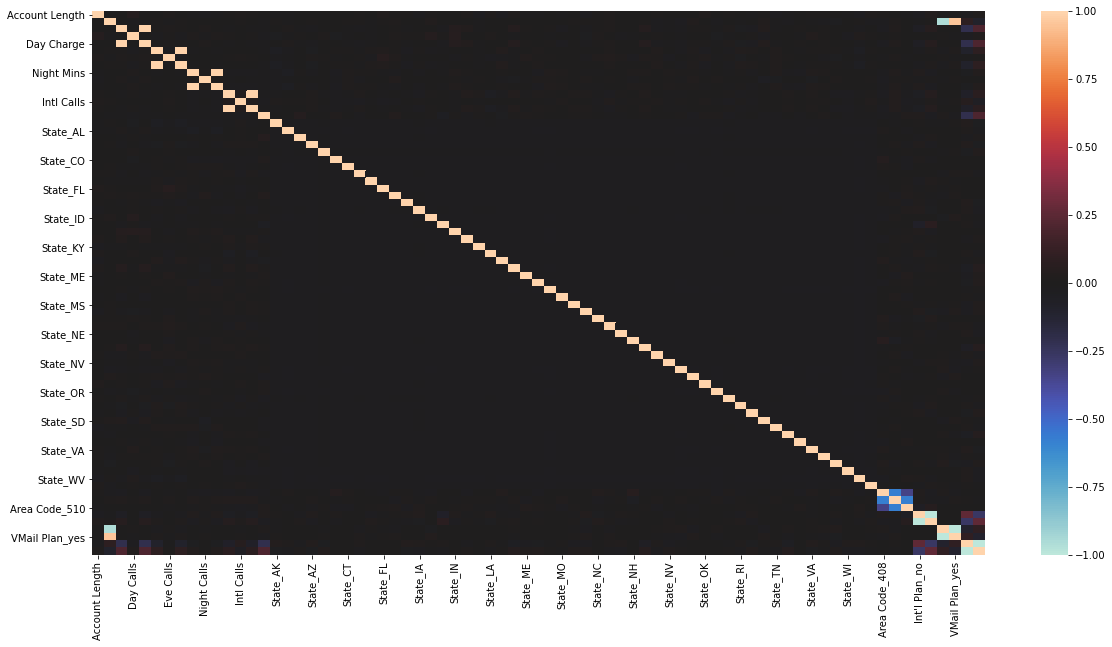

In [17]:
#creating 2D correlation matrix
g = sns.heatmap(df_clean.corr(),annot=False,vmin=-1, vmax=1,center=0)
g.figure.set_size_inches(20,10)

Observations:
    
- It's very hard to read this figure with so much data.
- Some features have perfect correlations.
- There are important correlations between Churn and the other variables!
- No obvious correlations between State and anything else.

Let's drop all of the State variables since those weren't correlated and take a closer look.

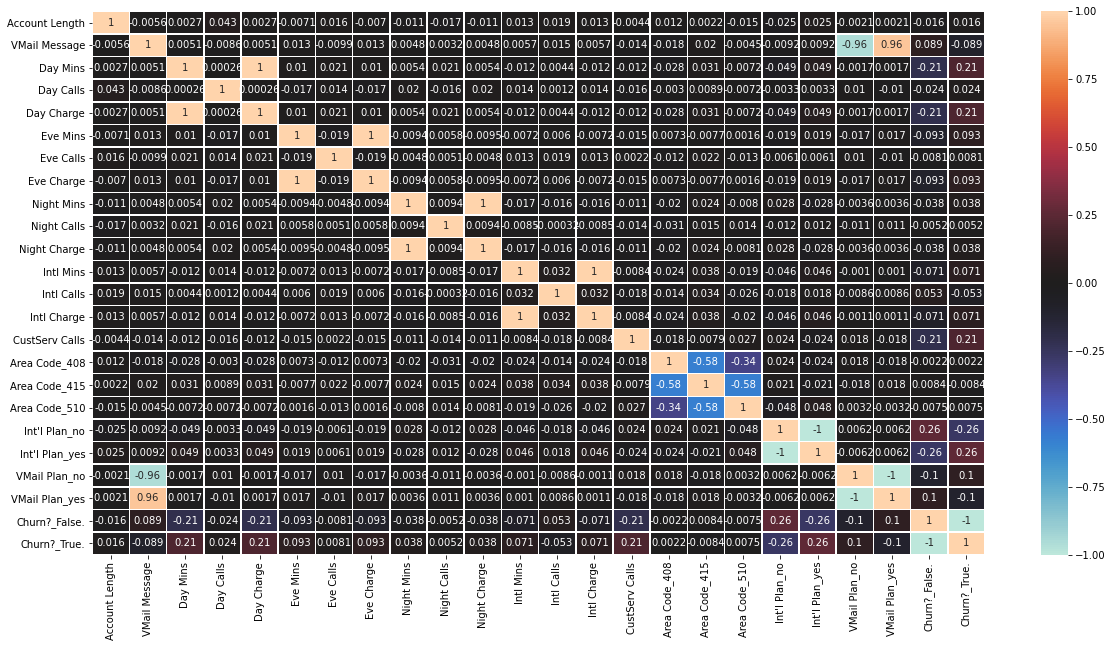

In [18]:
#creating 2D correlation matrix
g = sns.heatmap(df_clean.loc[:,df_clean.columns.str.contains('State')==False].corr(),annot=True,vmin=-1, vmax=1, center= 0, yticklabels=1, linewidths=.5)
g.figure.set_size_inches(20,10)

There are clear instances of multicollinearity in this set:
- Day Charge ~ Day Mins
- Eve Charge ~ Eve Mins
- Night Charge ~ Night Mins
- Intl Charge ~ Intl Minutes
- VMail Message ~ VMail Plan
- All binary features have perfect correlation with their opposite value


- Charge ~ Mins: The customers are being charged at a rate of \\$/min.  When call time increases, charges go up by exactly \\$/min amount.
    - Drop the charge features.  The mins might be more interpretable since we don't really care about the rate.
- VMail: If someone doesn't pay for voicemail, then they won't have any voicemail messages.  Even if this isn't absolutely true (eg. 1 voicemail + voicemail plan), the correlation is close enough to 1 to justify removing the feature.
    - Strangely, Intl'l Plan doesn't correlate strongly with Intl Mins
    - Drop the VMail Plan feature.  This can always be determined from VMail Message.
- Binary features: If a value is true then it can't be false.
    - Drop the negative features since those are less intuitive.
    
We also find that most of the variables are uncorrelated with Churn.  I'll remove everything less than 0.01 (except VMail Message which is -0.009).  Two concerns with using uncorrelated data to predict an outcome are:
- Optimization - Removing unnecessary features will reduce the number of parameters in our model and will result in faster fitting times.
- Overfitting - It's possible that the model learns to use an "on average" uncorrelated feature to identify some specific samples in the training set.  However we know that on average, that feature does not correlate to the outcome class.  The specific learned behavior (and model weights) in this case won't generalize to an unseen test set.

Renaming the columns isn't strictly necessary (especially since the ML model doesn't care about column labels), but it may be helpful for futher EDA or result interpretation.

In [19]:
df_clean.drop(['Day Charge','Eve Calls', 'Eve Charge','Night Calls', 'Night Charge', 'Intl Charge', "Int'l Plan_no", "VMail Plan_yes","VMail Plan_no", "Churn?_False.",
               'State_AK', 'State_AL', 'State_AR','State_AZ',
              'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL',
       'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC',
       'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI',
       'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Area Code_408', 'Area Code_415', 'Area Code_510'
              
              
              ], axis=1, inplace=True)
df_clean.rename(columns={"Int'l Plan_yes": "Intl Plan", "VMail Plan_yes": "VMail Plan", "Churn?_True.": "Churn"}, inplace=True)

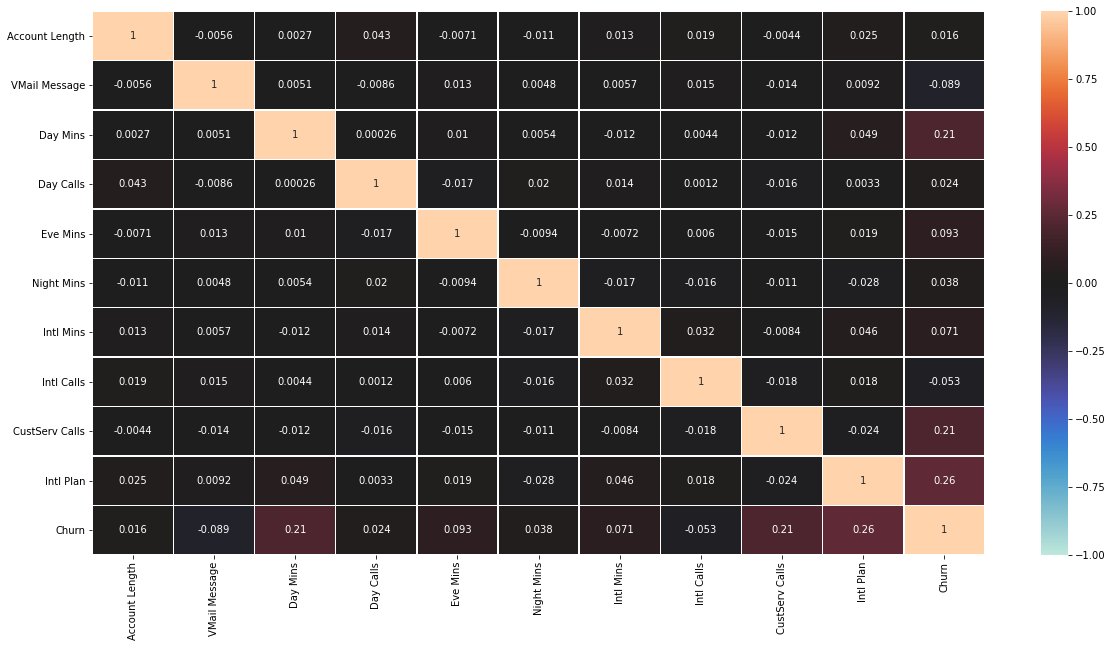

In [20]:
#creating 2D correlation matrix
g = sns.heatmap(df_clean.corr(),annot=True,vmin=-1, vmax=1, center= 0, yticklabels=1, linewidths=.5)
g.figure.set_size_inches(20,10)

## Provide code and results in your submission addressing the following questions:

### 2: [20pt] Allowed libraries: sklearn, pandas, Keras  and Tensorflow. Report (code and results)

Part a) [10 pt]
Use preprocessed churn dataset from Q1 to create a 4-layer artificial neural network (ANN) and specifically a feed-forwardmultilayer perceptron (with sigmoid activations and MSE loss function) to perform multi-class
classification to classify 'Churn' based on other variables and describe the topology of the model (how many layers, how many neurons at each layer). 

The variables of the datset are explained in the link provided above. Split the data into training and testing set by 70:30 and use the training set for training the model and the test set to evaluate the model performance. Please note that this is a binary classification problem so select the right number of nodes accordingly for the output layer. Also report precision and recall. 

In this solution I use the Adam optimizer since it performs better on this dataset and model.  The optimizer decision is case dependent, but often you will see Adam used as the standard optimizer.  Adam is loosely derived from SGD and the key differences between SGD and Adam are that it includes a "momentum" term, which tends to increase the rate of convergence and avoid saddle points, and that it iteration-averages the gradient to accommodate high variance in batch-to-batch gradients.  You may have noticed that Keras implements a version of SGD that can use momentum as well.

It's fine if you used either SGD or Adam in your solutions. I wanted to make sure that I could demonstrate a working example for you even though we haven't worked with Adam in this course.

I am assigned a random_state to train_test_split and using a specific seed for the kernel_initializers in order to create a reproducible example.

In [21]:
train, test = train_test_split(df_clean, train_size=0.7, random_state=42)

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=(len(train.loc[:,train.columns != 'Churn'].columns))),
        layers.Dense(10, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
        layers.Dense(10, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
        layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    ]
)

# using Adam as optimizer since it converges, whereas SGD does not
model.compile(optimizer='adam', loss='mse', 
              metrics=["accuracy",
                        keras.metrics.Precision(name="precision",thresholds=0.5),
                        keras.metrics.Recall(name="recall",thresholds=0.5)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Source: https://keras.io/guides/writing_your_own_callbacks/
# Discussion 10-30

class WeightLoggerCallback(keras.callbacks.Callback):
    def on_train_batch_end(self,batch,logs=None):
        
        # model weights
        # get_weights: (n_iterations, 2 (weights + bias), (n_inputs, n_layer_size) or (n_layer_size))
        temp = self.model.layers[1].get_weights()
        training_weights.append(temp)
        
        # model accuracy
        # the call to evaluate will be *very* slow, but is necessary for 2b.
        # the validation loss is only evaluated every epoch and is unavailable at end of batch
        loss, acc, prec, recall = self.model.evaluate(test.loc[:,test.columns != 'Churn'], test['Churn'], verbose=0)
        error_log.append({'batch': batch, 'training': logs['accuracy'], 'test': acc})

The fit_args are defined here so that we can re-use them between the different models.  This should make it easier for us to compare between models.

In [24]:
# default batch_size is 32, including here to be explicit
fit_args = {'epochs': 200, 'verbose':0, 'batch_size':32}

In [25]:
training_weights = []
error_log = []

# basic example
history = model.fit(train.loc[:,train.columns != 'Churn'], train['Churn'], **fit_args, callbacks= [WeightLoggerCallback()], validation_data=(test.loc[:,test.columns != 'Churn'], test['Churn']))

# better: use a validation set
# history = model.fit(train.loc[:,train.columns != 'Churn'], train['Churn'], **fit_args, callbacks= [WeightLoggerCallback()], validation_split=0.8);

**Solution:**

If
- precision and recall provided as metrics to compile
- validation_data is set to the test data

Then
- precision, recall are answer for training data
- val_precision, val_recall are answer for test data

In [26]:
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}

{'precision': 0.5151515007019043,
 'recall': 0.2266666740179062,
 'val_precision': 0.5076923370361328,
 'val_recall': 0.22758620977401733}

If
- precision and recall provided as metrics to compile

In [27]:
# training
model.evaluate(train.loc[:,train.columns != 'Churn'], train['Churn']);

73/73 [==============================] - 0s 1ms/step - loss: 0.0948 - accuracy: 0.8730 - precision: 0.6475 - recall: 0.2679


In [28]:
# test
model.evaluate(test.loc[:,test.columns != 'Churn'], test['Churn']);

32/32 [==============================] - 0s 1ms/step - loss: 0.1033 - accuracy: 0.8554 - precision: 0.5077 - recall: 0.2276


If
- using precision and recall in standalone mode from keras or equiavalent

In [29]:
training_predictions = model.predict(train.loc[:,train.columns != 'Churn'])
test_predictions = model.predict(test.loc[:,test.columns != 'Churn'])

In [30]:
m_precision = tf.keras.metrics.Precision(thresholds=0.5)
m_precision.update_state(train['Churn'],training_predictions)
print(f"Training Precision: {m_precision.result().numpy()}")
m_precision.reset_states()
m_precision.update_state(test['Churn'],test_predictions)
print(f"Test Precision: {m_precision.result().numpy()}")

Training Precision: 0.6474820375442505
Test Precision: 0.5076923370361328


In [31]:
m_recall = tf.keras.metrics.Recall(thresholds=0.5)
m_recall.update_state(train['Churn'],training_predictions)
print(f"Training Recall: {m_recall.result().numpy()}")
m_recall.reset_states()
m_recall.update_state(test['Churn'],test_predictions)
print(f"Test Recall: {m_recall.result().numpy()}")

Training Recall: 0.2678571343421936
Test Recall: 0.22758620977401733


### Part b) [10 pt] 

Provide two plots: 1)the weight values per iteration for the last layer, 2) training and test error
per iteration. Use stochastic gradient descent with back-propagation. When reporting error, use the ratio of misclassified samples. 

In both of these plots we can see that our model is nearly converged.  For it to be completely converged at the global minimum though we would expect the last few iterations to be completely flat.  Here they look like they're changing ever so slightly.  This could be a matter of hyperparameter tuning (eg. learning rate, momentum).

<AxesSubplot:>

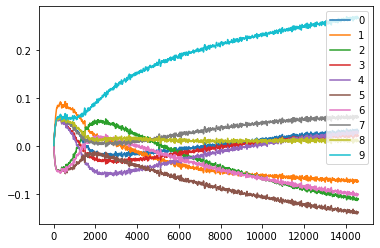

In [32]:
biases = [x[-1] for x in training_weights]

pd.DataFrame(biases).plot()

<AxesSubplot:>

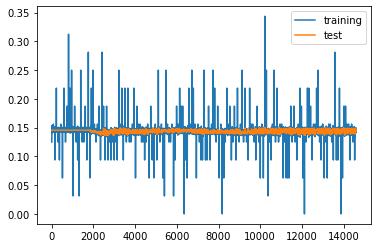

In [33]:
pd.DataFrame(error_log)[['training','test']].apply(lambda x: 1-x).plot()

### 3: [10 pt]
Now re-train the ANN with all your data (all samples). What is your training error?


By using more data, we expect that the training error will be less.

Example using no validation split

In [34]:
model.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])

training_weights = []
history = model.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args)
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall']}

{'precision': 0.8265682458877563, 'recall': 0.46569645404815674}

Example using validation split

In [35]:
model.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])

training_weights = []
history = model.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args, validation_split=0.8)
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}

{'precision': 0.8199999928474426,
 'recall': 0.44565218687057495,
 'val_precision': 0.8684210777282715,
 'val_recall': 0.4241645336151123}